<a href="https://colab.research.google.com/github/rpradata-ud/DSPS_RPradata/blob/main/HW/HW6/Submit_HW6_DSPS_gaussian_process_regression_RPradata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino

!pip install george
import george
from george import kernels

from scipy.optimize import minimize

Note for self:

Study resources for Gaussian processes:

https://gaussianprocess.org/

https://gaussianprocess.org/gpml/chapters/


# NB

Code skeletons are provided for you, but you may change them as you please.

It is not required, but I suggest you adjust and complete the given docstrings as you make changes.

# 0. The Dataset

We'll be using the El Niño dataset from the `statsmodels` package. This first cell of code loads the dataset easily for you. Read the description of the dataset [here](https://www.statsmodels.org/devel/datasets/generated/elnino.html).

In [2]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """

    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()

I initially had the x (time) in the format "1950JAN,...etc.", but found out it wouldn't work in the gp.compute() function because they were strings. Hence, I changed it (and the interpolated time t with format "1950JAN1,...etc.") to the form of integers.

The "time" result in flatten_dataset is shown as the "mid month" of each month, as the surface temperature data is given as averages in each month.

In [3]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    The sea surface temperature data is stored in a somewhat peculiar way in
    this dataset. The data has rows for every year between 1950 and 2010, and
    it has 12 columns for each month of each year.

    Re-order the data such that there is one 1-dim array for the temperature data.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    time : array-like
        A shape (732,) array containing every month from January 1950 to
        December 2010. You may encode the time as an integer
        (`time = [0, 1, 2, 3, ...]), as strings (`time = ['January 1950', ...])
        or however else you like.
    data : array-like
        A shape (732,) array containing the sea surface temperature for every
        month between January 1950 to December 2010.
    """
    # YOUR CODE HERE

    data = np.array([])
    time = np.array([])
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    num_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    ind = [0,1,2,3,4,5,6,7,8,9,10,11]

    count = 0 #for num of days
    for r in range(2011-1950):
      year = (1950+r)
      if year % 4 ==0:
        num_days[1] = 29
      else:
        num_days[1] = 28
    for i, r in df.iterrows():
      temp_in_year = np.array([r[1], r[2], r[3], r[4], r[5], r[6], r[7], r[8], r[9], r[10], r[11], r[12]])
      data = np.append(data, temp_in_year)

      for i in ind:
        #for 31 days, middle val is 16. 30, set to 15. for 29, is 15. for 28, is 18
        if num_days[i]==31:
          mid_days = 16
          day = count + mid_days
          count += num_days[i]
        if num_days[i] ==30:
          mid_days = 15.5
          day = count + mid_days
          count += num_days[i]
        if num_days[i] ==29:
          mid_days = 15
          day = count + mid_days
          count += num_days[i]
        if num_days[i]==28:
          mid_days = 14.5
          day = count + mid_days
          count += num_days[i]
        time = np.append(time, day)

    return time, data



x, y = flatten_dataset(df)

len(x), x.max()

(732, 22250.0)

# 1. Visualize

minimum Temp (Celcius): 18.9
maximum Temp (Celcius): 29.2


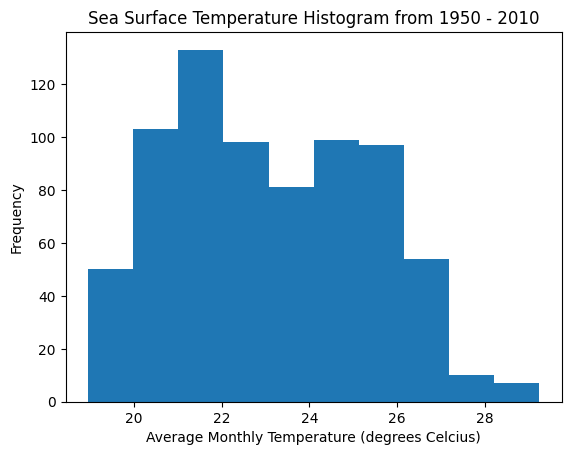

In [4]:
def visualize_hist(df):
    """
    Visualize the El Niño – Sea Surface Temperature dataset.

    You decide the most appropriate way to visualize the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    None
    """
    # YOUR CODE HERE
    x, y = flatten_dataset(df)
    plt.hist(y)
    plt.xlabel("Average Monthly Temperature (degrees Celcius)")
    plt.ylabel("Frequency")
    plt.title("Sea Surface Temperature Histogram from 1950 - 2010")
    print("minimum Temp (Celcius): {:.1f}".format(np.min(y)))
    print("maximum Temp (Celcius): {:.1f}".format(np.max(y)))



    plt.show




    # raise NotImplementedError()

visualize_hist(df)

Figure 1: Histogram of the averaged monthly sea surface temperature (in degrees Celcius) from 1950 - 2010. The temperatures range between 18.9 and 29.2 degrees Celcius throughout the time, and seem to peak towards ~22 degrees Celcius.

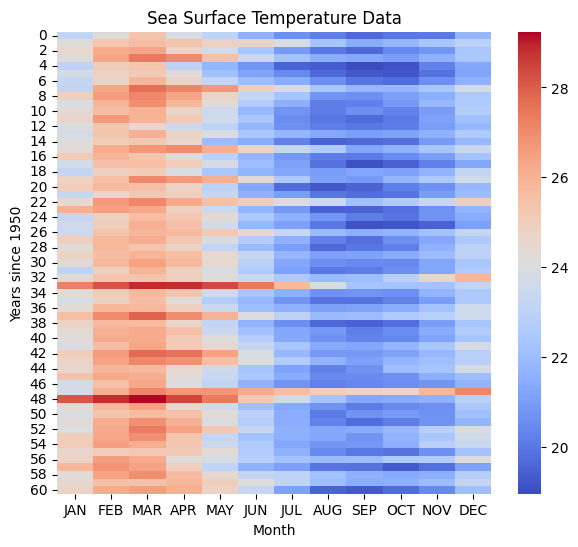

In [5]:
def visualize_colormap(df):

  plt.figure(figsize=(7, 6))
  sns.heatmap(df.iloc[:, 1:], cmap="coolwarm", cbar=True)
  plt.xlabel("Month")
  plt.ylabel("Years since 1950")
  plt.title("Sea Surface Temperature Data")

    #label the colorbar?

  plt.show()

visualize_colormap(df)


Figure 2: Heatmap showing the average sea surface temperature variations throughout the months of a year, from 1950 to 2010. The colorbar to the right of the plot shows the temperature colors. Throughout the year, the temperature seems to follow a consistent pattern of fluctuating between higher and lower temperatures (as we can see, the left half of the map tends towards red (higher temp) and the right half tends towards blue (lower temp)). This is our first indication that our data is periodic.



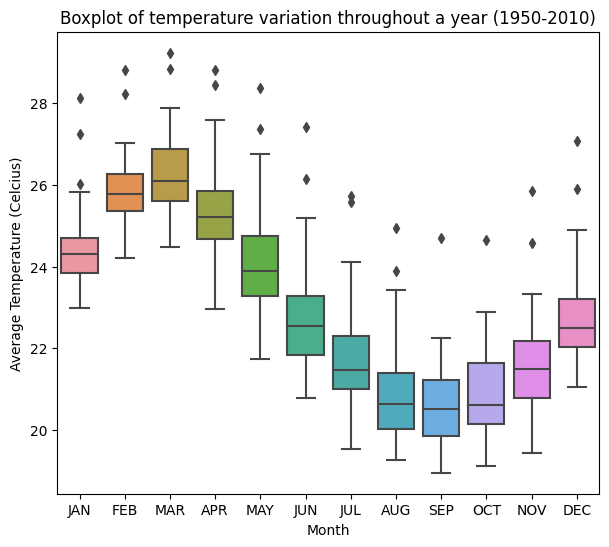

In [6]:
def visualize_boxplot(df):

  plt.figure(figsize=(7, 6))
  sns.boxplot(data=df.iloc[:, 1:])

  plt.title("Boxplot of temperature variation throughout a year (1950-2010)")
  plt.ylabel("Average Temperature (Celcius)")
  plt.xlabel("Month")

  plt.show()

visualize_boxplot(df)

#https://builtin.com/data-science/boxplot

Figure 3: Boxplot showing the distribution of temperatures throughout the months of a year, from the years 1950 - 2010 in the dataset. The boxplot shows the interquartile range and median average temperatures for each month (computed throughout the years in the data). In this graph, we see a clearer fluctuation of the temperature values throughout the year, indicating that this dataset is periodic.

# 2. Gaussian Process Regression (GPR)

In [7]:
#https://george.readthedocs.io/en/latest/tutorials/first/

#Note for self: Gaussian Process is for interpolation.


In [8]:
def get_interpolated_time():
    """
    We are going to use GPR to interpolate the sea surface temperatures for
    every day between January 1st 1950 and December 1st 2030. There are 29,555
    days between those two dates (inclusive). Create and return an array of
    times for each day in that timeframe.

    Paramters
    ---------
    None

    Returns
    -------
    t : array-like
        A shape (29555,) array, the times we want to interpolate. Encoded the
        same way you did before or any way you like.
    """
    # YOUR CODE HERE


    t = np.array([])
    ind = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    num_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    count = 1

    for r in range(2031-1950):
      year = (1950+r)
      if year % 4 ==0:
        num_days[1] = 29
      else:
        num_days[1] = 28

      days_in_year = np.sum(num_days)

      for d in range(days_in_year):
        date = count + d
        t = np.append(t, date)

        # if (year == 2030) and d == 334:
        #   break
        if len(t) == 29555:
          break
      if len(t) == 29555:
          break

      count += days_in_year

    return t


t = get_interpolated_time()

len(t)

29555

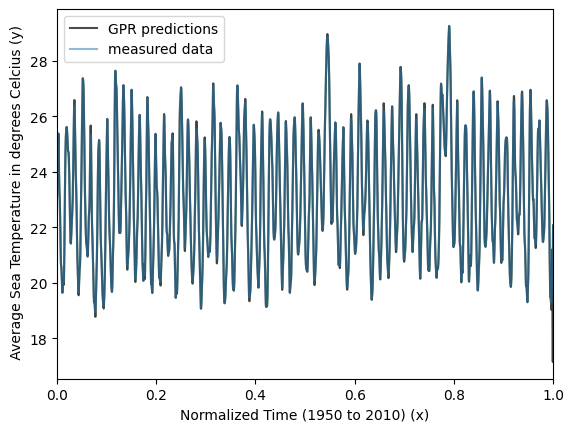

In [9]:
def gaussian_process_regression_normalized(time, data, interp_time, initial_guess):
    """
    Using the george package, its documentation and startup guide, implement a
    gaussian process regressor on `time` and `data`. Then, use it to predict
    on `interp_time`.

    It will be helpful for you to write code to visualize the result of this
    initial model, but not necessary for the assignment.

    Parameters
    ----------
    time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month.
    data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day.
    initial_guess : array-like or float
        The intial guess for the gaussian process that you make. The number of
        parameters will depend on the kernel you choose.

    Returns
    -------
    None
    """

    #kernel is to make a covariance matrix
    # YOUR CODE HERE
    kernel = np.var(data) * kernels.ExpSquaredKernel(initial_guess)

    gp = george.GP(kernel)

###
    cond_t = interp_time <= time.max()
    interp_time = interp_time[cond_t]

###

    norm_x = (time-time.min())/(time.max()-time.min())
    norm_t = (interp_time-interp_time.min())/(interp_time.max()-interp_time.min())



    gp.compute(norm_x, yerr=0)

    pred, pred_var = gp.predict(data, norm_t, return_var=True)

    plt.fill_between(norm_t, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                    color="g", alpha=0.2) #tho this part doesn't help much, because we don't have yerr. this line corresponds to error.

    plt.plot(norm_t, pred, "k", lw=1.5, alpha=0.7, label="GPR predictions")
    plt.plot(norm_x, data, alpha = 0.5, label="measured data")
    plt.xlabel("Normalized Time (1950 to 2010) (x)")
    plt.ylabel(" Average Sea Temperature in degrees Celcius (y)");
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend()

    plt.show()



initial_guess = 0.00001
gaussian_process_regression_normalized(x, y, t, initial_guess)

Figure 4: The GPR run to predict temperature during each day within the time range in the data (months between Jan 1, 1950 to 2010). The kernel used here is exponential squared, with initial guess (metric parameter) of 0.00001. Note that the x-axis is in normalized time, for both time in the prediction and actual data, from Jan 1, 1950 to 2010. I chose to use the exponential squared kernel as it was simply like a default kernel, so I assumed it would somehow work in most kinds of data.

The GPR process seems to work quite well here. It mostly lines up with the graph of the actual data. We can also see that the data here is periodic, which is what we have seen and expected in part 1.

In this run, we can infer that the Gaussian Process Regression works quite well with sole interpolation.

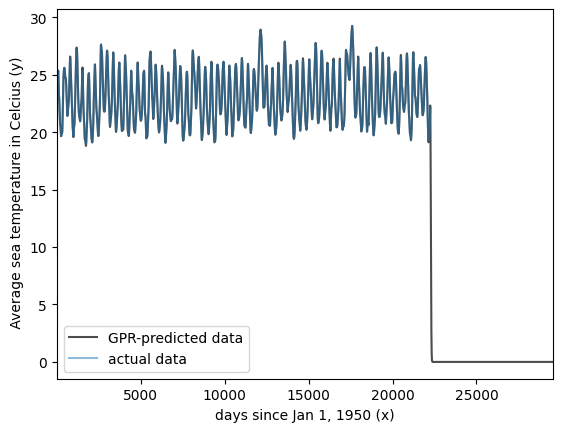

In [10]:
def gaussian_process_regression_2(time, data, interp_time, initial_guess):
    """
    Using the george package, its documentation and startup guide, implement a
    gaussian process regressor on `time` and `data`. Then, use it to predict
    on `interp_time`.

    It will be helpful for you to write code to visualize the result of this
    initial model, but not necessary for the assignment.

    Parameters
    ----------
    time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month.
    data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day.
    initial_guess : array-like or float
        The intial guess for the gaussian process that you make. The number of
        parameters will depend on the kernel you choose.

    Returns
    -------
    None
    """

    metric = initial_guess
    kernel = np.var(data) * kernels.ExpSquaredKernel(metric) #+ * kernels.ExpSine2Kernel(scale, period)  #+ kernels.ExpSquaredKernel(1, 365)

    gp = george.GP(kernel)

    # norm_x = abs(time-interp_time.min())/abs(interp_time.max()-interp_time.min())
    # norm_t = abs(interp_time-interp_time.min())/abs(interp_time.max()-interp_time.min())

    norm_x = time
    norm_t = interp_time

    gp.compute(norm_x, yerr=0)

    pred, pred_var = gp.predict(data, norm_t, return_var=True)

    plt.plot(norm_t, pred, "k", lw=1.5, alpha=0.7, label="GPR-predicted data")
    plt.plot(norm_x, data, alpha = 0.5, label="actual data")
    plt.xlabel("days since Jan 1, 1950 (x)")
    plt.ylabel(" Average sea temperature in Celcius (y)");
    plt.xlim(0.0, 0.6)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend()

    plt.show()


initial_guess = 1000
gaussian_process_regression_2(x, y, t, initial_guess)

Figure 5: The GPR run to predict the temperature during every day from Jan 1, 1950, to Dec 1, 2030. The same kernel was used, but with initial guess (metric parameter) 1000. As with Figure 4, the GPR process works well within the range of time measured (in the interpolation part). However, beyond 2010, the GPR predictions seem to constantly read 0 degrees Celcius throughout the end of the "interpolated" time period (Dec 1, 2030). Hence here, the GPR process does not seem to extrapolate the data in a way one would expect, using this particular kernel.


(Also, different initial guesses give different results/graph shapes)


# 3. Optimize

In [11]:
#Rayta::

def optimize(time, data, initial_guess):
    """
    Using any optimization method you choose, find the optimal set of
    hyperparameters for your model.
    Print the results of your optimization.
    Parameters
    ----------
    time : array, original data time
    data : array, original data temps
    interp_time : array, values 0 - 29554
    initial_guess : int, initial guess for kernel
    Returns
    -------
    result.x : array, optimized hyperparameters for kernel
    pred : array, predicted temp values
    pred_var : array, predicted temp values variance
    """


    t = get_interpolated_time()

    norm_x = abs(time-t.min())/abs(t.max()-t.min())
    norm_t = abs(t-t.min())/abs(t.max()-t.min())

    kernel = np.var(data) * kernels.ExpSquaredKernel(initial_guess)
    gp = george.GP(kernel, mean = data.mean(), white_noise = 0, fit_mean = True, fit_white_noise = True)

    gp.compute(norm_x)
    pred, pred_var = gp.predict(data, norm_t, return_var=True)
    # print(gp.get_parameter_dict())
    from scipy.optimize import minimize

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(data)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(data)

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    gp.set_parameter_vector(result.x)

    # print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
    pred, pred_var = gp.predict(data, norm_t, return_var=True)

    print(result)

    print("the optimal set of hyperparameters is {}".format(result.x))

    return result.x, pred, pred_var
    # raise NotImplementedError()
initial_guess = 0.000001
result, pred, pred_var = optimize(x, y, initial_guess)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 730.8949904179717
        x: [ 2.307e+01 -2.871e+00  1.670e+00 -1.197e+01]
      nit: 20
      jac: [ 4.176e-07  2.620e-07 -6.700e-08 -5.386e-06]
 hess_inv: [[ 4.306e-02 -1.579e-04  5.087e-06  8.957e-05]
            [-1.579e-04  1.037e-02  4.238e-03  6.219e-03]
            [ 5.087e-06  4.238e-03  1.212e-02  6.560e-03]
            [ 8.957e-05  6.219e-03  6.560e-03  8.156e-03]]
     nfev: 24
     njev: 24
the optimal set of hyperparameters is [ 23.07240974  -2.87123353   1.66995723 -11.96715405]


My initial optimization function wasn't working with the predictions to be plotted in Part 4 anymore. I spent a long time trying to figure it out, and so Tali really helped me with this.

Notes to self:
The function in #2 is different than in this optimizer fn #3. That's why here I define a different gp from before.

^about the optimization:
I went to office hours to clarify what the documentation was talking about.

In documentation, the neg_ln_like only had p (parameter vector) as input, meanwhile I need to define y explicitly here.

in the minimize function, gp.get(parameter_vector) will give the initial guess. The jac = grad_neg_ln_like would speed up the process.

 (Analogy of: a ball exploring a surface, and then it gets "stuck" at a certain hill. How does it determine where to move? The gradient at that point would give information.)

# 4. Visualize your model

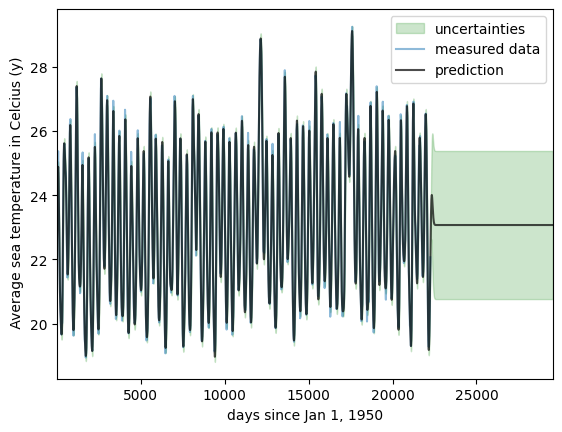

In [12]:
def visualize_model():
    """
    Visualize your model. Use any method you like in visualizing your model but
    you must make at least one plot with a figure caption. Your
    visualization must also plot the uncertainties from the GP model.

    In your figure caption, comment on the effectiveness of your model in
    predicting temperatures beyond 2010.

    Parameters
    ----------


    Returns
    -------

    """
    plt.fill_between(t, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="g", alpha=0.2, label='uncertainties') #tho this part doesn't help much, because we don't have yerr. this line corresponds to error.
    plt.plot(x, y, alpha = 0.5, label='measured data')
    plt.plot(t, pred, "k", lw=1.5, alpha=0.7, label='prediction')
    # plt.errorbar(t, pred, yerr=pred_var, fmt=".k", capsize=0)
    plt.xlabel("days since Jan 1, 1950")
    plt.ylabel(" Average sea temperature in Celcius (y)");
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend()

    plt.show()

    # YOUR CODE HERE


visualize_model()

Figure 6: The optimized GPR process to predict average sea temperatures for each day from 1950 to December 1, 2030, using the optimization function defined in part 3, with initial guess (metric parameter for the exp. sqaured kernel) 0.000001. The uncertainties are also plotted. In this optimized Gaussian process, the predictions within the given time range (interpolation) seems to work as well as it did in Figures 4 & 5. Moreover, in comparison to Figure 5, the predicted temperatures after 2010 seem to stay at a constant value, yet does not read at 0 degrees celcius. Instead, it predicts a more reasonable temperature, around 23 degrees Celcius (around the mean of the existing measured data). In addition, after 2010, the uncertainties are also shown to be constant and quite large at around +/- 2 degrees Celcius (and we can see that the extrapolated prediction with these uncertainties would almost "fit" most of the measured data). In some way, it tries to make up for the constant temperature prediction.

Therefore, from this study, one can infer that the Gaussian Process Regression, with the exponential squared kernel, might not work the best in predicting the temperatures beyond the given measured data on its own. However, optimizing the hyperparameters in our run helps us get a more reasonable prediction, although it still outputs a constant value for the prediction.



On a side note, I also computed the optimized GPR for initial guess = 1000 as with what we did for part #2, but it ended up predicting the temperature being at the constant mean value throughout. Hence, varying the initial guesses, in addition to variation of kernels, can change the outcome of our Gaussian processes

(Also, a more useful way to have this plot is to have the x-axis in terms of years, but I didn't have time to change everything)